# Autoencoders
So far in this course we have done many **supervised** classification tasks - we have a datset (like MNIST) where each of our samples that we use for training has both **features** and **labels**.   The goal of training our classifier is then to come up with an algorithm that can predict labels correctly when presented with **unseen** or new data.

![supervised vs unsupervised learning](files/super_vs_unsuper.png)

In the graphic above on the left, the data is labeled as either blue circles or red crosses.  The goal of supervised learning is to discover the boundary between these two labeled datasets.
Unsupervised training is different.  In this case, the goal of the algorithm is to learn features present in the data, but without necessarily knowing the labels of that data.   In the above graphic on the right, the goal is discover that there are 3 groups present in our dataset, even though the data itself had no labels prior to analysis.


## Types of unsupervised learning
1.  Clustering: As in the graphic above, our primary goal is to portion our data into meaningful subsets.
2.  Anomaly detection: This is similar to clustering, except that here we are more interested in finding items in our data which are outliers not associated with the larger parent group(s).
3.  Autoencoders: These are a special form of unsupervised learing algorithm which form the subject of this workbook.   The goal here is to design a network whose output is a reasonably faithful representation of its input.   How can that be useful?
   * We can use the learned algorithm to discover features in our input data - and those features are the actual goal (not reproducing our image for example).
   * We can use this learned algorithm as a form of compression.
   * We can use the algorithm to accomplish anomaly detection.
   * We can use the algorithm to denoise input data.
   
Let's see how we can do most (if not all) of these things.

## Basics of Autoencoders
The following diagram illustrates the underlying idea of an autoencoder:

![ae](files/autoencoder_schema.jpg)

In this case, the autoencoder receives an image (the digit 2 in this case) and the goal of the full network is to reproduce the image on output.  

Some important points:
1.  Both the encoder and the decoder can be fully connected networks or convolutional neural networks.   The "autoencoder network" is the **combination** of the encoder followed by the decoder.
2.  It will be useful in some instances to implement the autoencoder as one full continuous network.   But it will be useful in other cases to define **separate** encoder and decoder networks.   More on this later.
3.  The key idea is that the **compressed representation** uses a smaller amount of data than the input data image.
    * This compression or **dimensionality reduction** is what makes autoencoders similar to Principal Components Analysis (PCA). PCA works by transfoming a higher dimensional dataset into a lower dimensional form.  The transformations that PCA uses are linear.   In fact, if only linear activations are used, an autoencoder is nearly equivalent to PCA.
4.  An autoencoder is usually data dependent, but should be useful for data it has not been trained on, as long as that **new data is similar** to the training data.   An autoencoder for digits will probably not be useful when applied to human faces.

As we have done many times, we will use handwritten digits for many of our initial tests.   However, to illustrate some interesting properties of autoencoders, we will use a variant called EMNIST.

## The EMNIST Data Sample
The extension of MNIST - which only uses the 10 digits from 0-9 - to include letters is called EMNIST.   We have used a version of this before, but now we will gain access to the full sample.   

A description of this dataset can be found in this [document](https://arxiv.org/pdf/1702.05373.pdf).

I have put this sample on the **scratch** area on the supercomputer, so there is no need to copy it to your local directory.   The location is here:

/fs/scratch/PAS1043/physics6820/emnist/matlab/emnist-byclass.mat

The file format is a **mat** file, and manipulating it is a bit tricky.  An example of how to open it an access the data inside of the mat file is given below:

In [1]:
from keras.datasets import mnist
import numpy as np
import scipy.io as sio
#
# See this for more info: https://arxiv.org/pdf/1702.05373.pdf
mat = sio.loadmat('/fs/scratch/PAS1495/physics6820/emnist/matlab/emnist-byclass.mat')
#print(mat)

data = mat['dataset']

ex_train = data['train'][0,0]['images'][0,0]
ey_train = data['train'][0,0]['labels'][0,0]
ex_test = data['test'][0,0]['images'][0,0]
ey_test = data['test'][0,0]['labels'][0,0]

ex_train = ex_train.reshape( (ex_train.shape[0], 28,28), order='F')
ex_test = ex_test.reshape( (ex_test.shape[0], 28,28), order='F')

ex_train = ex_train.reshape( (ex_train.shape[0], 784))
ex_test = ex_test.reshape( (ex_test.shape[0], 784))
ex_train = ex_train.astype('float32') / 255.
ex_test = ex_test.astype('float32') / 255.


Using TensorFlow backend.


In [2]:
unique, counts = np.unique(ey_train, return_counts=True)
for digit,count in zip(unique, counts):
    print("digit",digit,"; count ",count)

digit 0 ; count  34585
digit 1 ; count  38374
digit 2 ; count  34203
digit 3 ; count  35143
digit 4 ; count  33535
digit 5 ; count  31416
digit 6 ; count  34232
digit 7 ; count  35754
digit 8 ; count  33946
digit 9 ; count  33847
digit 10 ; count  6407
digit 11 ; count  3878
digit 12 ; count  10094
digit 13 ; count  4562
digit 14 ; count  4934
digit 15 ; count  9182
digit 16 ; count  2517
digit 17 ; count  3152
digit 18 ; count  11946
digit 19 ; count  3762
digit 20 ; count  2468
digit 21 ; count  5076
digit 22 ; count  9002
digit 23 ; count  8237
digit 24 ; count  24983
digit 25 ; count  8347
digit 26 ; count  2605
digit 27 ; count  5073
digit 28 ; count  20764
digit 29 ; count  9820
digit 30 ; count  12602
digit 31 ; count  4637
digit 32 ; count  4695
digit 33 ; count  2771
digit 34 ; count  4743
digit 35 ; count  2701
digit 36 ; count  10033
digit 37 ; count  5159
digit 38 ; count  2854
digit 39 ; count  10177
digit 40 ; count  24631
digit 41 ; count  2561
digit 42 ; count  3687
dig

## Subselect just the digits
In order to easily select just the digits from the EMNIST data, we dump the numpy arrays into a pandas dataframe, then pull out those with labels <= 9 (i.e. the digits from 0..9).

We will want to do something similar later, when we want to just look at letters (those samples with labels >= 10).

In [3]:
import pandas as pd

df_train = pd.DataFrame(ex_train)
df_train['label'] = ey_train
df_digits_train = df_train[df_train['label']<=9]
x_train = df_digits_train.iloc[:,:784].values
y_train = df_digits_train['label'].values

df_test = pd.DataFrame(ex_test)
df_test['label'] = ey_test
df_digits_test = df_test[df_test['label']<=9]
x_test = df_digits_test.iloc[:,:784].values
y_test = df_digits_test['label'].values


In [4]:
df_digits_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345035 entries, 2 to 697929
Columns: 785 entries, 0 to label
dtypes: float32(784), uint8(1)
memory usage: 1.0 GB


## A very simple autoencoder
Below we will make a very simple autoencoder using a fully connected network.   This network consists of the following:
1.  An input layer: This is just the 784 pixels from the image.
2.  The encoder: this layer has 784 inputs, and ecoding_dim=128 outputs.
3.  The decoder: this layer takes the 128 outputs of the encoder as input, then has 784 outputs.

The specific choice of parameters below is motivated by a discussion of autoencoders on the keras [blog](https://blog.keras.io/building-autoencoders-in-keras.html).

In [5]:
from keras import models
from keras import layers
from keras import regularizers

# this is the size of our encoded representations
encoding_dim = 128  
#
# Define out model
network = models.Sequential()
#
# This is the "encoder"
network.add(layers.Dense(encoding_dim,activation='relu',input_shape=(28*28,)))
#
# This is the decoder
network.add(layers.Dense(28*28,activation='sigmoid'))
#
# Now compile the network!
network.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['mse'])
print("network: ",network.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
network:  None


# How does the network know to autoencode?
The **autoencoding** comes in the fitting step: remember that the **first** argument of the keras **fit** method is the input vector of features (here this is of length 784), while the **second** method is the target.   Previously when doing classification, the target was the **labels** of the data (for MNIST this wold have been the one-hot encoding of the digit value).  Here we instead set the input=x_train **AND** the target=x_train.

Question: how many epochs do we choose?  This is chosen mainly by experiment.  In this case, if you go out to 50 epochs you will find that that performance plateaus around 20-25 epochs.  I have set the number of epochs to 25.

In [6]:
history = network.fit(x_train, x_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 345035 samples, validate on 57918 samples
Epoch 1/25
345035/345035 [==============================] - 14s 40us/step - loss: 0.2779 - mean_squared_error: 0.0553 - val_loss: 0.2135 - val_mean_squared_error: 0.0326
Epoch 2/25
345035/345035 [==============================] - 14s 39us/step - loss: 0.1921 - mean_squared_error: 0.0257 - val_loss: 0.1763 - val_mean_squared_error: 0.0206
Epoch 3/25
345035/345035 [==============================] - 14s 40us/step - loss: 0.1664 - mean_squared_error: 0.0176 - val_loss: 0.1583 - val_mean_squared_error: 0.0151
Epoch 4/25
345035/345035 [==============================] - 13s 38us/step - loss: 0.1523 - mean_squared_error: 0.0133 - val_loss: 0.1473 - val_mean_squared_error: 0.0118
Epoch 5/25
345035/345035 [==============================] - 14s 41us/step - loss: 0.1434 - mean_squared_error: 0.0106 - val_loss: 0.1402 - val_mean_squared_error: 0.0097
Epoch 6/25
345035/345035 [==============================] - 13s 39us/step - loss: 0.1376 - mean_squ

## Save the network
We may want to use this network later, so lets save it!   Use a reasonable name so we can tell what it is!

In [7]:
#print(history.history)
network.save('ae_fcn_'+str(encoding_dim)+'.h5')  # "tag" the file with the number of dimensions

## Performance
To examine performance, we can first look to see if our autoencoder is completely trained.   Looking at loss and mean-squared error ("mse") for train vs test, we see that at ~25 epochs, the autoencoder looks close to plateau, which is good.

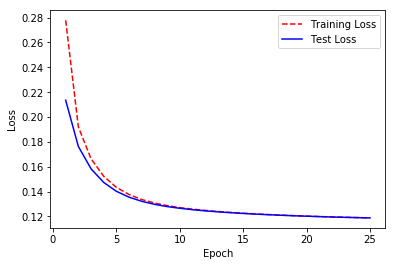

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

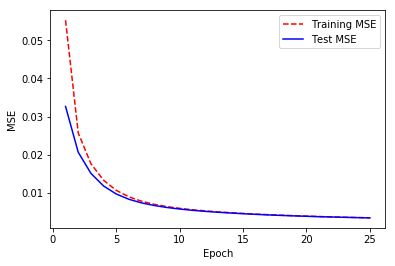

In [9]:
# Get training and test loss histories
training_loss = history.history['mean_squared_error']
test_loss = history.history['val_mean_squared_error']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training MSE', 'Test MSE'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show();

## Performance, Part II
Next we can try the "eye test": do the images at output look close to the images at input?

To test this, we first run all of our **test** (unseen by the network during training) images through the **predict** function of our network:

In [10]:
decoded_imgs = network.predict(x_test)
print("decoded_imgs.shape",decoded_imgs.shape)

decoded_imgs.shape (57918, 784)


## Performance, Part II (continued):
Now we can take a random set of digits (we use the first 10 below) from our test sample, and compare the original images with the output of our autoencoder for those same images.   Note that the output images look close - but there is some blurriness to them.

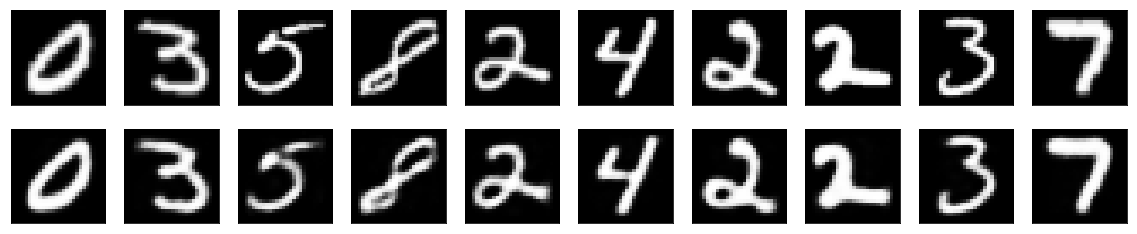

In [11]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Anomaly detection
There is a simple way we can use our autoencoder for **anomaly** detection.   Anomalies are data that appear to not belong to the parent distribution.   How can we define anomalies?

In this case we will use **mse**.   Remember the mse represents the average squared difference between the input pixels and the output pixels.   Let's first look at a historgram of the mse values for the full test sample.   We use the pandas DataFrame **hist** method (which is a built-in matplotlib function) to do this:

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


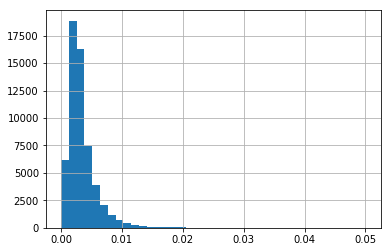

In [12]:
import numpy as np
import pandas as pd
#
# Now get the MSE for the decoded images
decoded_imgs = network.predict(x_test)   # we did this above, but since it is fast we do it again for clarity
mse = np.mean(np.power(x_test-decoded_imgs, 2), axis=1)
df_digits_test['mse'] = mse

hist = df_digits_test['mse'].hist(bins=np.linspace(0.0,0.05,40))

## Anomaly Detection, part II
We see above that most digits have mse < 0.01.   How about if we apply our algorithm to the **letters** in thr EMNIST dataset?  Remeber that these are the samples which have labels>9.

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


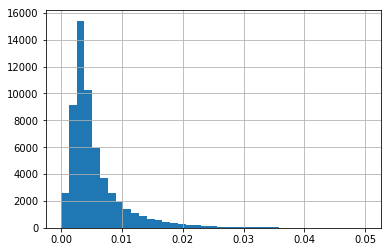

In [13]:
#
# NOw do the MSE for the letters
df_letters_test = df_test[df_test['label']>9]
x_test_letters = df_letters_test.iloc[:,:784].values
y_test_letters = df_letters_test['label'].values
decoded_letters_imgs = network.predict(x_test_letters)
mse_letters = np.mean(np.power(x_test_letters-decoded_letters_imgs, 2), axis=1)
df_letters_test['mse'] = mse_letters

hist = df_letters_test['mse'].hist(bins=np.linspace(0.0,0.05,40))

## Anomaly Detection, Part 3
Whereas almost all of the digits have mse<0.01, a significant fraction of letters have mse>0.01.   

Lets look at 10 **digits** that have large mse, 10 **letters** that have large mse, and 10 letters that have small (good) mse.   Try playing around with the mse cut values.   Do you notice any trends?

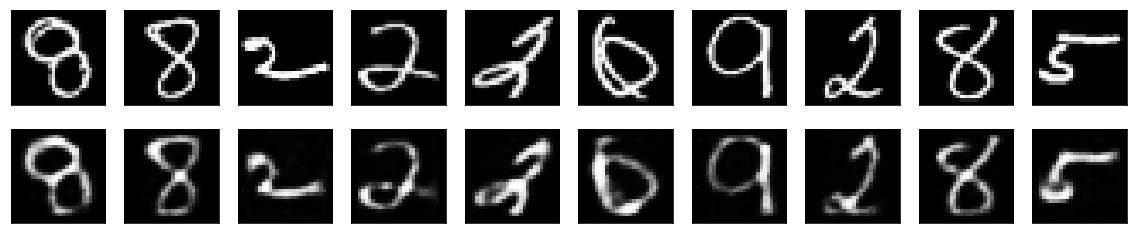

In [14]:
#df_digits_test_bad_mse = df_digits_test[(df_digits_test['mse']<0.014)]
df_digits_test_bad_mse = df_digits_test[(df_digits_test['mse']>.014)]

x_test_mse = df_digits_test_bad_mse.iloc[:,:784].values
y_test_mse = df_digits_test_bad_mse['label'].values

decoded_imgs_bad_mse = network.predict(x_test_mse)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_mse[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_bad_mse[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Large mse Letters

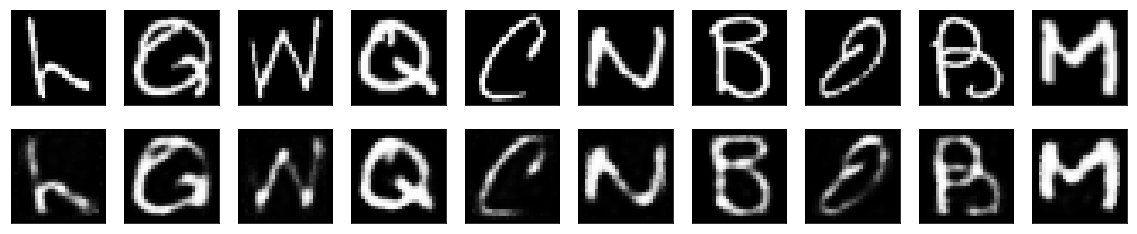

In [15]:
df_letters_test_bad_mse = df_letters_test[(df_letters_test['mse']>0.014)]

x_test_mse = df_letters_test_bad_mse.iloc[:,:784].values
y_test_mse = df_letters_test_bad_mse['label'].values

decoded_imgs_bad_mse = network.predict(x_test_mse)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_mse[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_bad_mse[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Small mse letters

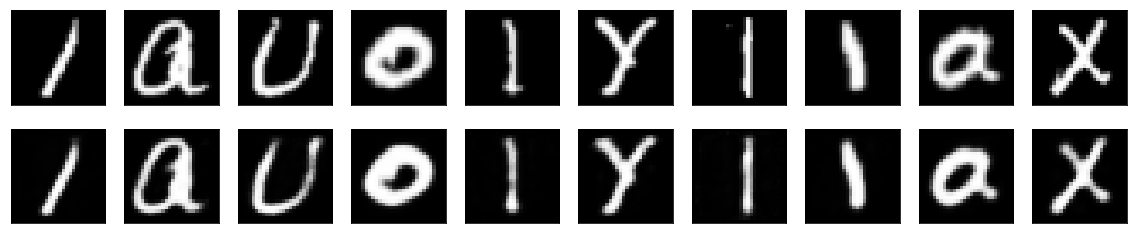

In [16]:
df_letters_test_bad_mse = df_letters_test[(df_letters_test['mse']<0.005)]

x_test_mse = df_letters_test_bad_mse.iloc[:,:784].values
y_test_mse = df_letters_test_bad_mse['label'].values

decoded_imgs_bad_mse = network.predict(x_test_mse)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_mse[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_bad_mse[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()